In [1]:
from pandas import Series, DataFrame
import pandas as pd
from patsy import dmatrices
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn import neighbors, metrics, model_selection, naive_bayes, tree
from datetime import datetime
from numpy import exp
import warnings
warnings.filterwarnings('ignore')
%pylab inline

def is_currency(s):
    '''Takes in an element of the series and outputs if it is a currency'''
    return (s.isupper() and len(s) == 3)

# Create the currency conversions for both pledged and goal
# Conversion valid April 10, 2018 @ 12:00 PM Central Time
currency_conversions = {
    'USD': 1.000000,
    'GBP': 1.41540,
    'CAD': 0.793289,
    'EUR': 1.23490,
    'AUD': 0.776080,
    'SEK': 0.120317,
    'NZD': 0.736415,
    'DKK': 0.165835,
    'NOK': 0.128176,
    'CHF': 1.04558,
    'MXN': 0.0547386,
    'SGD': 0.763829,
    'HKD': 0.127393,
    'JPY': 0.00931953
}

def currency_conversion(df):
    '''Takes in an df and outputs the conversion'''
    for k,v in currency_conversions.iteritems():
        
        # Create a make for the currency
        mask_currency = (df['currency'] == k)
        df.loc[mask_currency, 'usd_goal_current'] = df['goal'] * v
        df.loc[mask_currency, 'usd_pledged_current'] = df['pledged']  * v
    return df

def clean_states(e):
    '''Takes in an elements and returns if it is in a clean state'''
    return (e in ['failed', 'successful', 'suspended', 'canceled'])


def get_month(e):
    '''Takes in a datetime element and returns the month'''
    return e.month

def name_month(e):
    '''Takes in an element from a series, and outputs the 
    string representation of the month'''

    month = int(e)
    return months[month]

months = {
    1: 'January',
    2: 'February',
    3: 'March',
    4: 'April',
    5: 'May',
    6: 'June',
    7: 'July',
    8: 'August',
    9: 'September',
    10: 'October',
    11: 'November',
    12: 'December'
}

def get_days(e):
    '''Takes in a DateTime element from a series and 
    returns the number of days'''
    return e.days

# Load the csv
df = pd.read_csv('ks-projects-201801.csv')

# Drop countries with name N,0"
mask_country_drop = (df['country'] != 'N,0"')
df = df[mask_country_drop]

print len(df['country'].value_counts())
print df['goal'].max()
print df['usd_pledged_real'].max()
print df['usd_goal_real'].max()

# Convert the currency into today's price
df = currency_conversion(df)

# Convert the deadline and launched columns into dtype: datetime
df['deadline'] = pd.to_datetime(df['deadline'], format='%Y-%m-%d')
df['launched'] = pd.to_datetime(df['launched'], format='%Y-%m-%d %H:%M:%S')

# Add a 'month' and 'year' coloumn to the df
df['month_deadline'] = df['deadline'].map(get_month)
df['month_launched'] = df['launched'].map(get_month)

# Add an average pledge per backer
df['average_pledged'] = df['pledged'] / df['backers']

# Create a cateogy for the month launched, goals, and quarter launched
df['month_named'] = df['month_launched'].map(name_month).astype('category')

# Bin goal amount
df['goal_binned'] = pd.qcut(df['usd_goal_real'], 10)

# Bin the months into quarters
df['quarter_binned'] = "Q1"
mask_q1 = (df['month_launched'] <= 3)
mask_q2 = ((df['month_launched'] > 3) & (df['month_launched'] <= 6))
mask_q3 = ((df['month_launched'] > 6) & (df['month_launched'] <= 9))
mask_q4 = (df['month_launched'] > 9)

df.loc[mask_q1, 'quarter_binned'] = "Q1"
df.loc[mask_q2, 'quarter_binned'] = "Q2"
df.loc[mask_q3, 'quarter_binned'] = "Q3"
df.loc[mask_q4, 'quarter_binned'] = "Q4"
df['quarter_binned'] = df['quarter_binned'].astype('category')

# Get the length of the project
df['project_length'] = df['deadline'] - df['launched']
df['project_length_days'] = df['project_length'].map(get_days)
df['project_length_days_binned'] = pd.qcut(df['project_length_days'], 3)
# print df['project_length_days'].value_counts()

# Get a baseline for the ML
# The first part is going to predict based off of cateogrical variables: 
# category, month-launched, month-deadline

# There are 6 states: failed, successful, canceled, undefied, lived, suspended
# For classification purposes 1.0 = successful, 0.0 = failed, suspended, canceled
# Create a mask of just the clean states
mask_clean_states = (df['state'].map(clean_states))
df_clean_states = df[mask_clean_states]

# Get the value counts for the clean states
vc_clean_states = df_clean_states['state'].value_counts()

# Find the baseline by dividing the total of project by the number of successful projects
# baseline = 0.359806607575
num_total_projects = vc_clean_states.sum()
num_successful_projects = vc_clean_states['successful']
baseline = float(num_successful_projects) / float(num_total_projects)

# Create a dummy binary variable for success or fail/cancel/suspended
df_clean_states['target'] = 0.0
mask_target = df_clean_states['state'] == 'successful'
df_clean_states.loc[mask_target, 'target'] = 1.0

C:\Users\tracetschida\Anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Populating the interactive namespace from numpy and matplotlib
22
100000000.0
20338986.27
166361390.71


In [2]:
df = df_clean_states
print df.columns.values

['ID' 'name' 'category' 'main_category' 'currency' 'deadline' 'goal'
 'launched' 'pledged' 'state' 'backers' 'country' 'usd pledged'
 'usd_pledged_real' 'usd_goal_real' 'usd_goal_current'
 'usd_pledged_current' 'month_deadline' 'month_launched' 'average_pledged'
 'month_named' 'goal_binned' 'quarter_binned' 'project_length'
 'project_length_days' 'project_length_days_binned' 'target']


# Kinds of main categories and count for each

In [3]:
df['main_category'].value_counts()

Film & Video    62365
Music           49249
Publishing      39080
Games           34939
Technology      32185
Design          29762
Art             27959
Food            24416
Fashion         22562
Theater         10871
Comics          10743
Photography     10730
Crafts           8733
Journalism       4723
Dance            3749
Name: main_category, dtype: int64

# Kinds of secondary categories and count for each

In [4]:
#there is 159 different secondary categories. 
#Here are the top 15!
df['category'].value_counts()[:15]

Product Design    22074
Documentary       16081
Tabletop Games    14070
Music             13260
Shorts            12311
Video Games       11743
Food              11453
Film & Video       9170
Fiction            9119
Fashion            8514
Nonfiction         8267
Art                8190
Apparel            7056
Theater            7048
Technology         6847
Name: category, dtype: int64

## Which categories get the most funding (per country)

country              
AT       Design          2.393579e+06
         Film & Video    2.162712e+06
         Technology      1.148452e+07
AU       Film & Video    8.151900e+07
         Games           4.702265e+07
         Technology      1.884812e+08
BE       Food            5.628572e+06
         Games           2.763404e+06
         Technology      6.851507e+06
CA       Art             1.026948e+08
         Film & Video    2.041010e+08
         Technology      1.350237e+08
CH       Film & Video    5.958815e+07
         Food            1.065037e+08
         Technology      1.396185e+07
DE       Film & Video    1.217178e+08
         Games           3.376345e+07
         Technology      7.167438e+07
DK       Design          4.118669e+06
         Publishing      1.501658e+07
         Technology      6.940083e+06
ES       Games           1.736922e+07
         Technology      4.345379e+07
         Theater         1.715745e+07
FR       Art             3.409803e+07
         Games           1.3

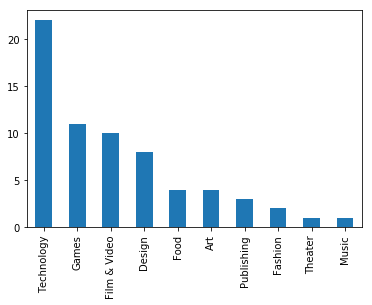

In [130]:
df2 = df.groupby(['country','main_category'])['usd_goal_real'].agg('sum')


def sort(a):
    return a.sort_values(ascending=False)[:3]

df2 = df2.unstack('country').apply(sort)
df2 = df2.T.stack()
with pd.option_context('display.max_rows', None, 'display.max_columns', 3):
    print df2
    
df2.groupby(level=[1]).agg('count').sort_values(ascending=False).plot(kind='bar')

# Categories with most backers

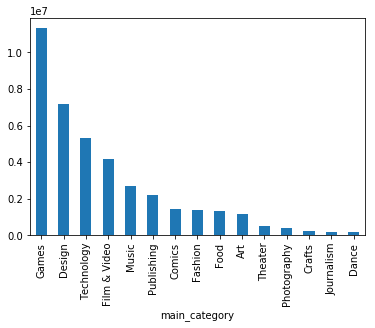

In [6]:
df.groupby(['main_category'])['backers'].agg('sum').sort_values(ascending=False).plot(kind='bar')

# Countries that provide the most funding (top 5)

In [7]:
df.groupby(['country'])['usd_goal_real'].agg('sum').sort_values(ascending=False)[:5]

country
US    1.273959e+10
GB    1.434133e+09
CA    6.528791e+08
AU    4.540834e+08
NL    3.112826e+08
Name: usd_goal_real, dtype: float64

# Goal amounts that get the most funding 

In [8]:
def goal_amount(goal):
    if goal < 5000:
        return 'Less than $5,000 goal'
    elif goal < 10000:
        return 'Less than $10,000 goal'
    else:
        return 'Over $10,000 goal'
df['goal_bracket'] = df['goal'].map(goal_amount)
df.groupby(['goal_bracket'])['goal'].agg('sum').sort_values(ascending=False)

goal_bracket
Over $10,000 goal         1.763975e+10
Less than $10,000 goal    4.291546e+08
Less than $5,000 goal     2.806847e+08
Name: goal, dtype: float64

In [9]:
df

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,...,month_launched,average_pledged,month_named,goal_binned,quarter_binned,project_length,project_length_days,project_length_days_binned,target,goal_bracket
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.00,failed,...,8,NaN,August,"(1500.0, 2500.0]",Q3,58 days 11:47:32,58,"(31.0, 16738.0]",0.0,"Less than $5,000 goal"
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.00,failed,...,9,161.400000,September,"(20459.66, 46049.259]",Q3,59 days 19:16:03,59,"(31.0, 16738.0]",0.0,"Over $10,000 goal"
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.00,failed,...,1,73.333333,January,"(20459.66, 46049.259]",Q1,44 days 23:39:10,44,"(31.0, 16738.0]",0.0,"Over $10,000 goal"
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.00,failed,...,3,1.000000,March,"(4000.0, 5500.0]",Q1,29 days 20:35:49,29,"(-0.001, 29.0]",0.0,"Less than $10,000 goal"
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.00,canceled,...,7,91.642857,July,"(12500.0, 20459.66]",Q3,55 days 15:24:57,55,"(31.0, 16738.0]",0.0,"Over $10,000 goal"
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.00,successful,...,2,233.816964,February,"(46049.259, 166361390.71]",Q1,34 days 10:21:33,34,"(31.0, 16738.0]",1.0,"Over $10,000 goal"
6,1000023410,Support Solar Roasted Coffee & Green Energy! ...,Food,Food,USD,2014-12-21,1000.0,2014-12-01 18:30:44,1205.00,successful,...,12,75.312500,December,"(700.0, 1500.0]",Q4,19 days 05:29:16,19,"(-0.001, 29.0]",1.0,"Less than $5,000 goal"
7,1000030581,Chaser Strips. Our Strips make Shots their B*tch!,Drinks,Food,USD,2016-03-17,25000.0,2016-02-01 20:05:12,453.00,failed,...,2,11.325000,February,"(20459.66, 46049.259]",Q1,44 days 03:54:48,44,"(31.0, 16738.0]",0.0,"Over $10,000 goal"
8,1000034518,SPIN - Premium Retractable In-Ear Headphones w...,Product Design,Design,USD,2014-05-29,125000.0,2014-04-24 18:14:43,8233.00,canceled,...,4,141.948276,April,"(46049.259, 166361390.71]",Q2,34 days 05:45:17,34,"(31.0, 16738.0]",0.0,"Over $10,000 goal"
9,100004195,STUDIO IN THE SKY - A Documentary Feature Film...,Documentary,Film & Video,USD,2014-08-10,65000.0,2014-07-11 21:55:48,6240.57,canceled,...,7,145.129535,July,"(46049.259, 166361390.71]",Q3,29 days 02:04:12,29,"(-0.001, 29.0]",0.0,"Over $10,000 goal"


# Greatest successfully funded category (top 3)

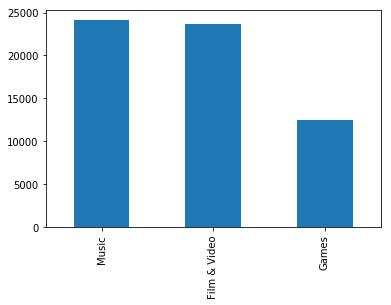

In [10]:
df[df['state'] == 'successful']['main_category'].value_counts()[:3].plot(kind='bar')

In [11]:
df[df['state'] == 'successful']['main_category'].value_counts()[:3]

Music           24105
Film & Video    23612
Games           12518
Name: main_category, dtype: int64